# Sistema de Recomendação
## Baseado em Matrix Factorization SVD

Autores: Andrei Donati, Angelo Baruffi e Luís Felipe Pelison

O DataSet utilizado para este código é o MovieLens (https://grouplens.org/datasets/movielens/). 
A fim de teste, foi adicionado entradas referentes ao desenvolvedor. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
%matplotlib inline
import os
os.chdir('c:\\Andrei\\recommender-systems\\dataset')

### Importação dos dados para treino do algoritmo

In [2]:
ratings_df = pd.read_csv("ratings.csv", sep=",")
ratings_df = ratings_df.iloc[:,0:3]

ratings_df, ratings_df_test = train_test_split(
                                ratings_df, test_size=0.05, random_state=42)

movies_df = pd.read_csv("movies.csv", sep=",")
movies_df['movieId'] = movies_df['movieId'].apply(pd.to_numeric)

me  = np.max(ratings_df['userId']) +1
print("Number of my user is "+str(me))

Number of my user is 672


Adicionando os meus dados

In [3]:
my_ratings= pd.DataFrame([[me, 1, 3.5 ],[ me,135861, 4.5], [ me,133824, 1], [ me,130634, 5]  , [ me,116797, 4.5], 
                           [ me,114662, 4], [ me,112897, 4], [ me,112497, 2], [ me,112370, 3.5],
                           [ me,112183, 5], [ me,110553, 3.5], [ me,109673, 4.5], [ me,108932, 1], 
                           [ me,50189, 4], [ me,59784, 3.5], [ me,61123, 1], [ me,61160, 2], 
                           [ me,62999, 4], [ me,63515, 4.5], [ me,67923, 4.5],
                           [ me,68157, 5]], columns=['userId','movieId','rating']) 

print('Alguns filmes que gosto')
my_ratings.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').sort_values(by=['rating'], ascending=False).head(10)

Alguns filmes que gosto


,userId,movieId,rating,title,genres
20,672,68157,5.0,Inglourious Basterds (2009),Action|Drama|War
3,672,130634,5.0,Furious 7 (2015),Action|Crime|Thriller
9,672,112183,5.0,Birdman: Or (The Unexpected Virtue of Ignoranc...,Comedy|Drama
19,672,67923,4.5,"Fast & Furious (Fast and the Furious 4, The) (...",Action|Crime|Drama|Thriller
4,672,116797,4.5,The Imitation Game (2014),Drama|Thriller|War
18,672,63515,4.5,The Island (2006),Drama|Mystery
1,672,135861,4.5,Ted 2 (2015),Comedy
11,672,109673,4.5,300: Rise of an Empire (2014),Action|Drama|War|IMAX
13,672,50189,4.0,American Pie Presents The Naked Mile (American...,Comedy|Romance
5,672,114662,4.0,American Sniper (2014),Action|War


Une os datasets

In [4]:
ratings_df = ratings_df.append(my_ratings)

Cria matrix de Users x Filmes 

In [5]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df.head(8)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualização de algumas informações importantes

Entradas não nulas da matriz

In [6]:
print('% entradas não nulas: {:0.4f} %'.format(100*(np.count_nonzero(R_df>0.0)/(R_df.shape[0]*R_df.shape[1]))) )

% entradas não nulas: 1.5872 %


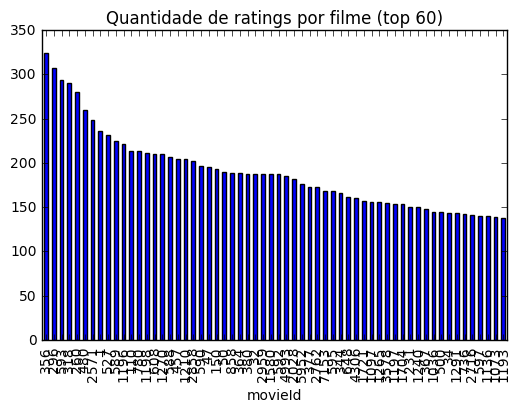

In [7]:
R_df[R_df>0.0].count(axis = 0).sort_values(ascending= False).head(60).plot(kind='bar', title='Quantidade de ratings por filme (top 60)')

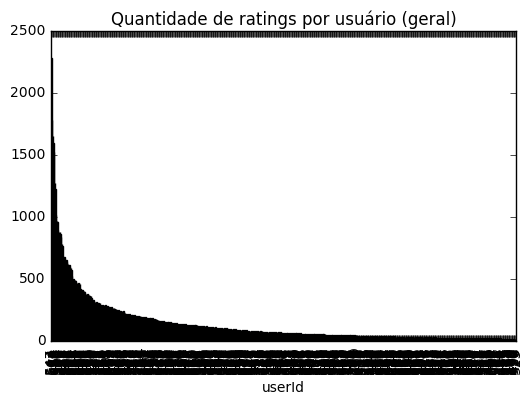

In [8]:
R_df[R_df>0.0].count(axis = 1).sort_values(ascending= False).plot(kind='bar', title='Quantidade de ratings por usuário (geral)')

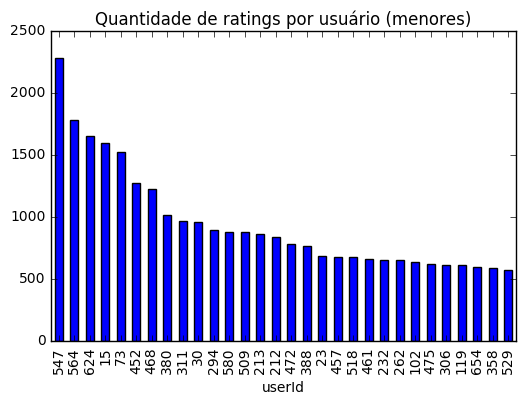

In [9]:
R_df[R_df>0.0].count(axis = 1).sort_values(ascending= False).head(30).plot(kind='bar', title='Quantidade de ratings por usuário (menores)')

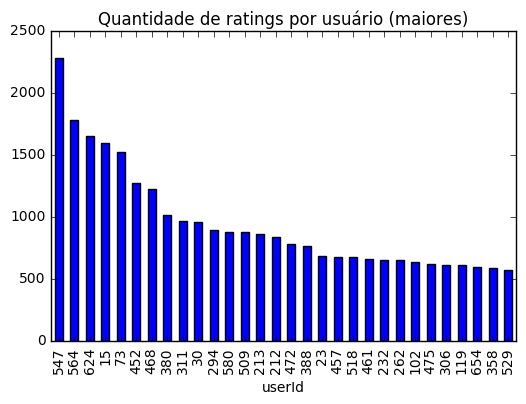

In [10]:
R_df[R_df>0.0].count(axis = 1).sort_values(ascending= False).head(30).plot(kind='bar', title='Quantidade de ratings por usuário (maiores)')

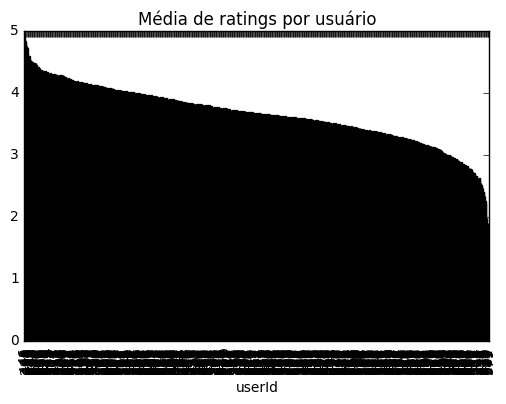

In [11]:
R_df[R_df>0.0].mean(axis = 1).sort_values(ascending= False).plot(kind='bar', title='Média de ratings por usuário')

### Algoritmo SVD

Substitui os valores nulos por 0 e transforma a matrix de reviews em uma matrix com uma diferença da média do usuário


In [12]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

Aplica a transformação SVD

In [13]:
U, sigma, Vt = svds(R_demeaned, k = 80)

sigma = np.diag(sigma)

Reconstroi a matrix de ratings

In [14]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings = all_user_predicted_ratings + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head(8)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.099005,0.049427,0.011699,-0.039027,-0.045565,0.060376,-0.013306,-0.019088,0.032981,0.038844,...,-0.007086,-0.005791,0.009265,-0.004256,-0.003700,0.001177,0.016582,-0.006479,-0.006034,-0.008803
1,0.388745,1.624741,-0.202489,0.174076,0.135105,0.177129,0.037123,0.072423,-0.006390,2.376564,...,-0.001970,-0.003118,-0.001988,0.001649,0.003152,-0.026364,-0.002302,0.000772,-0.000080,-0.002581
2,0.927754,0.063741,-0.177900,-0.058070,0.096517,-0.000337,-0.051324,-0.041342,-0.008672,0.040683,...,-0.001326,-0.002324,0.003538,-0.004491,-0.005152,-0.010566,0.006891,0.008892,0.004068,0.000517
3,0.465707,1.635466,0.539386,-0.157619,-0.061393,-1.748462,-0.150896,-0.144209,-0.048586,2.725049,...,0.007259,-0.002242,0.009448,0.010272,0.014039,0.049587,0.012803,-0.001722,0.000062,0.011779
4,0.905208,1.568860,0.601549,0.008675,0.777848,-0.124813,0.168821,0.087312,-0.201958,0.397355,...,-0.012172,-0.014483,0.005342,-0.003695,0.002272,-0.074354,0.015826,0.005696,-0.002834,-0.008716
5,0.421585,0.091281,-0.170213,0.082628,0.157149,-0.002793,-0.244321,-0.017793,-0.059705,-0.032360,...,-0.000463,-0.001502,0.002077,-0.002884,-0.002288,0.009422,0.005154,-0.013228,-0.009568,0.003152
6,2.749301,0.523698,0.563045,0.121625,-0.129795,-0.045831,0.416046,-0.059373,0.144835,0.839767,...,0.001748,-0.002066,-0.003695,0.005800,0.007473,-0.051292,-0.006770,0.018542,0.012106,0.001042
7,0.860668,0.053987,0.452131,0.056236,0.398331,-0.048852,0.177270,0.095783,0.052153,0.314126,...,-0.000071,0.008329,-0.002588,0.007136,0.004278,-0.116606,-0.010308,0.010885,0.011671,-0.012992


In [15]:
del U, sigma, Vt,  R, user_ratings_mean, all_user_predicted_ratings

Define alguns parâmetros

In [16]:
userId= me
num_recommendations= 10

Filtra os filmes já assistidos

In [17]:
user_row_number = userId - 1 

#pega as filmes que o usuário já assistiu
sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) 
    
user_data = ratings_df[ratings_df['userId'] == (userId)]
already_rated = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                sort_values(['rating'], ascending=False)
            )

print('Usuário {0} já deixou seu rating para {1} filmes.'.format(userId, already_rated.shape[0]) )
  

Usuário 672 já deixou seu rating para 21 filmes.


Busca as predições

In [18]:
predictions = (movies_df[~movies_df['movieId'].isin(already_rated['movieId'])].
                     merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                   left_on = 'movieId', right_on = 'movieId').
                   rename(columns = {user_row_number: 'Predictions'}).
                   sort_values('Predictions', ascending = False).
                   iloc[:num_recommendations, :-1]
                  )

print('Recomendando os top {0} filmes ainda não vistou pelo usuário.'.format(num_recommendations))

Recomendando os top 10 filmes ainda não vistou pelo usuário.


### Recomendações

In [19]:
predictions

,movieId,title,genres
2505,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
8764,122882,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
320,356,Forrest Gump (1994),Comedy|Drama|Romance|War
3804,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
8217,99114,Django Unchained (2012),Action|Drama|Western
7566,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
8526,109487,Interstellar (2014),Sci-Fi|IMAX
7547,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
7227,68954,Up (2009),Adventure|Animation|Children|Drama
231,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
